In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Dataset


In [ ]:
import os 
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from torchvision import transforms as T

In [ ]:
CLASS_NAMES = ['bottle', 'cable','capsule','carpet']

In [ ]:
dataset_path = '/content/drive/MyDrive/Padim/mvtec_anomaly_detection'
save_path = '/content/drive/MyDrive/Padim/mvtec_anomaly_detection/mvtec_result'

In [ ]:
class MVTecDataset(Dataset):
  def __init__(self, dataset_path=None, class_name= 'bottle', is_train=True, resize=256, cropsize=224):
    assert class_name in CLASS_NAMES, 'class_name: {}, should be in {}'.format(class_name,CLASS_NAMES)
    self.dataset_path = dataset_path
    self.class_name = class_name
    self.is_train = is_train
    self.resize = resize
    self.cropsize = cropsize

    #load dataset
    self.x, self.y, self.mask = self.load_dataset_folder()

    # set transforms
    self.transform_x = T.Compose([T.Resize(resize, Image.ANTIALIAS),
                                  T.CenterCrop(cropsize),
                                  T.ToTensor(),
                                  T.Normalize(mean=[0.485,0.456,0.406],
                                              std=[0.229,0.224,0.225])])
    self.transform_mask = T.Compose([T.Resize(resize, Image.NEAREST),
                                     T.CenterCrop(cropsize),
                                     T.ToTensor()])
  
  def __getitem__(self, idx):
    x,y,mask = self.x[idx], self.y[idx], self.mask[idx]

    x= Image.open(x).convert('RGB')
    x= self.transform_x(x)

    if y==0:
      mask= torch.zeros([1, self.cropsize, self.cropsize])
    else:
      mask = Image.open(mask)
      mask = self.transform_mask(mask)

    return x,y,mask
  
  def __len__(self):
    return len(self.x)
  
  def load_dataset_folder(self):
    phase = 'train' if self.is_train else 'test'
    x,y,mask = [], [], []

    img_dir = os.path.join(self.dataset_path, self.class_name, phase)
    gt_dir = os.path.join(self.dataset_path, self.class_name, 'ground_truth')

    img_types = sorted(os.listdir(img_dir))
    for img_type in img_types:

      img_type_dir = os.path.join(img_dir, img_type)
      if not os.path.isdir(img_type_dir):
        continue
      img_fpath_list = sorted([os.path.join(img_type_dir,f)
                              for f in os.listdir(img_type_dir)])
      x.extend(img_fpath_list)

      if img_type == 'good':
        y.extend([0]* len(img_fpath_list))
        mask.extend([None]* len(img_fpath_list))
      else :
        y.extend([1]* len(img_fpath_list))
        gt_type_dir = os.path.join(gt_dir, img_type)
        img_fname_list = [os.path.splitext(os.path.basename(f))[0] for f in img_fpath_list]
        gt_fpath_list = [os.path.join(gt_type_dir, img_fname + '_mask.png')
                        for img_fname in img_fname_list]
        mask.extend(gt_fpath_list)

    assert len(x) == len(y), 'number of x and y should be same'

    return list(x), list(y), list(mask)

# model

In [ ]:
import random
from random import sample
import argparse
import numpy as np
import pickle
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis
from skimage import morphology
from scipy.ndimage import gaussian_filter
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18



In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
import clip
from transformers import CLIPVisionModel, CLIPModel

In [ ]:
model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").register_forward_hook(hook)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.0.layer_norm1.weight', 'text_model.encoder.layers.1.mlp.fc2.weight', 'text_model.encoder.layers.2.self_attn.k_proj.bias', 'text_projection.weight', 'text_model.encoder.layers.3.self_attn.v_proj.bias', 'text_model.encoder.layers.4.layer_norm2.bias', 'text_model.encoder.layers.4.mlp.fc2.weight', 'text_model.encoder.layers.9.self_attn.q_proj.weight', 'text_model.encoder.layers.1.layer_norm1.weight', 'text_model.encoder.layers.7.layer_norm2.weight', 'text_model.encoder.layers.8.self_attn.q_proj.weight', 'text_model.encoder.layers.1.self_attn.out_proj.weight', 'text_model.encoder.layers.6.self_attn.q_proj.weight', 'text_model.encoder.layers.10.self_attn.out_proj.bias', 'text_model.encoder.layers.6.mlp.fc2.bias', 'text_model.encoder.layers.8.self_attn.k_proj.bias', 'text_model.encoder.layers.10.layer_norm2.weight', 'text_model.encoder.layers.3.laye

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.1

load train set feature from: /content/drive/MyDrive/Padim/mvtec_anomaly_detection/mvtec_result/temp_resnet18/train_bottle.pkl


| feature extraction | test | bottle |: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


image ROCAUC: 0.996
pixel ROCAUC: 0.981


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


load train set feature from: /content/drive/MyDrive/Padim/mvtec_anomaly_detection/mvtec_result/temp_resnet18/train_cable.pkl


| feature extraction | test | cable |: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


image ROCAUC: 0.855
pixel ROCAUC: 0.949


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


load train set feature from: /content/drive/MyDrive/Padim/mvtec_anomaly_detection/mvtec_result/temp_resnet18/train_capsule.pkl


| feature extraction | test | capsule |: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


image ROCAUC: 0.870
pixel ROCAUC: 0.982


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


load train set feature from: /content/drive/MyDrive/Padim/mvtec_anomaly_detection/mvtec_result/temp_resnet18/train_carpet.pkl


| feature extraction | test | carpet |: 100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


image ROCAUC: 0.984
pixel ROCAUC: 0.988
Average pixel ROCAUC: 0.975


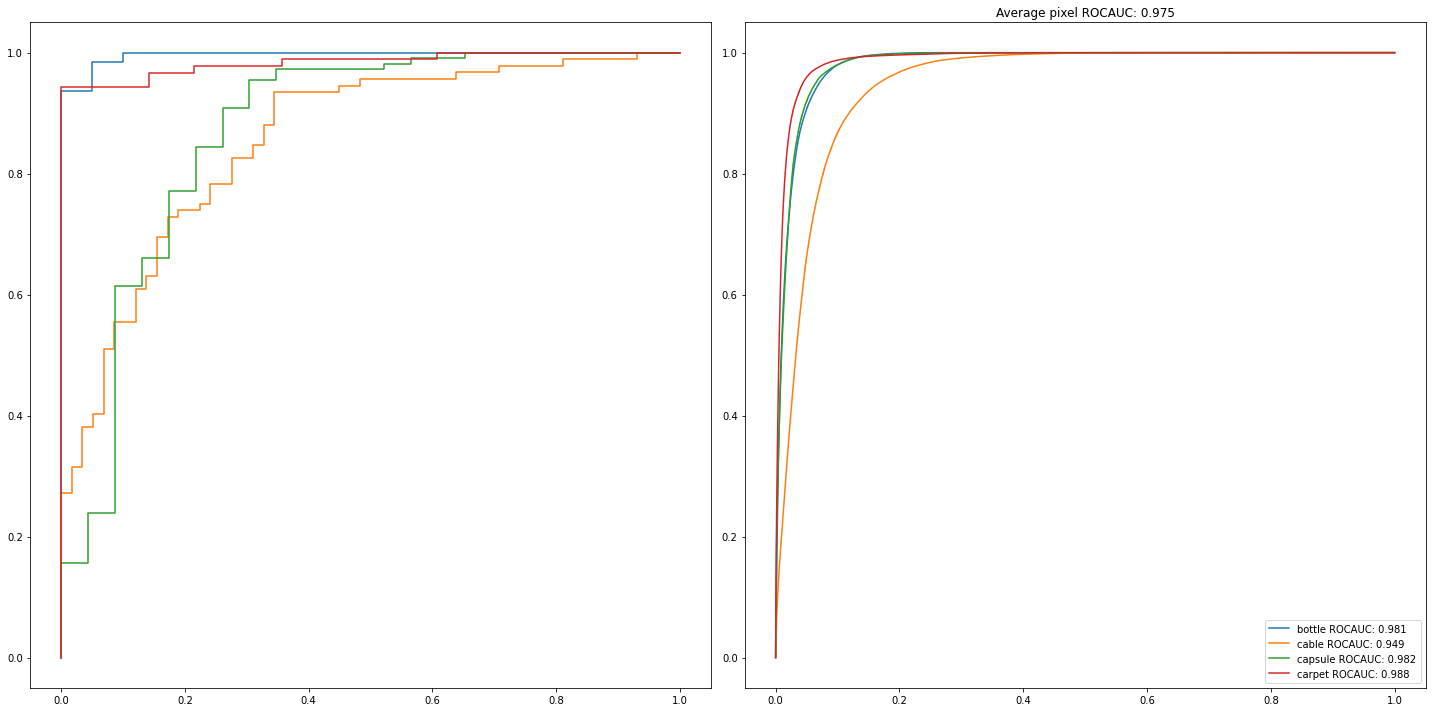

In [ ]:
def parse_args():
  parser = argparse.ArgumentParser('PaDim')
  parser.add_argument('--data_path', type=str, default='/content/drive/MyDrive/Padim/mvtec_anomaly_detection')
  parser.add_argument('--save_path', type=str,default='/content/drive/MyDrive/Padim/mvtec_anomaly_detection/mvtec_result')
  parser.add_argument('--arch', type=str, choices=['resnet18','wide_resnet50_2'], default='wide_resnet50_2')
  parser.add_argument('-f')
  return parser.parse_args()

model=''
def main():

  args= parse_args()
  global model
  # load model
  if args.arch =='resnet18':
    model = resnet18(pretrained=True, progress=True)
    t_d = 448
    d = 100

  elif args.arch =='wide_resnet50_2':
    model = wide_resnet50_2(pretrained=True, progress=True)
    t_d = 1792
    d= 550
  model.to(device)
  model.eval()
  random.seed(1024)
  torch.manual_seed(1024)
  if use_cuda:
    torch.cuda.manual_seed_all(1024)
  idx = torch.tensor(sample(range(0,t_d),d))

  outputs=[]

  def hook(module, input, output):
    outputs.append(output)

  model.layer1[-1].register_forward_hook(hook)
  model.layer2[-1].register_forward_hook(hook)
  model.layer3[-1].register_forward_hook(hook)

  os.makedirs(os.path.join(args.save_path, 'temp_%s' % args.arch), exist_ok=True)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  fig_img_rocauc= ax[0]
  fig_pixel_rocauc = ax[1]

  total_roc_auc= []
  total_pixel_roc_auc = []

  for class_name in CLASS_NAMES:
    train_dataset = MVTecDataset(args.data_path, class_name= class_name, is_train=True)
    train_dataloader= DataLoader(train_dataset,batch_size= 32, pin_memory=True)
    test_dataset = MVTecDataset(args.data_path, class_name= class_name, is_train=False)
    test_dataloader= DataLoader(test_dataset,batch_size= 32, pin_memory=True)

    train_outputs = OrderedDict([('layer1',[]),('layer2',[]),('layer3',[])])
    test_outputs = OrderedDict([('layer1',[]),('layer2',[]),('layer3',[])])

    # extract feature
    train_feature_filepath = os.path.join(args.save_path, 'temp_%s'% args.arch, 'train_%s.pkl'% class_name)
    if not os.path.exists(train_feature_filepath):
      for (x,_,_) in tqdm(train_dataloader,'| feature extraction| train | %s |' % class_name):
        #model prediction
        with torch.no_grad():
          _ = model(x.to(device))

        # get intermediate layer outputs
        for k, v in zip(train_outputs.keys(), outputs):
          train_outputs[k].append(v.cpu().detach())
        # initialize hook outputs
        outputs=[]

      for k,v in train_outputs.items():
        train_outputs[k] = torch.cat(v,0)


      # Embedding concat
      embedding_vectors = train_outputs['layer1']
      for layer_name in ['layer2','layer3']:
        embedding_vectors= embedding_concat(embedding_vectors, train_outputs[layer_name])

      # randomly select d dimension

      embedding_vectors = torch.index_select(embedding_vectors,1,idx)

      # calculate multivariate Gaussian distribution
      B, C, H, W = embedding_vectors.size()
      embedding_vectors = embedding_vectors.view(B, C, H * W)
      mean = torch.mean(embedding_vectors, dim=0).numpy()
      cov = torch.zeros(C,C,H*W).numpy()
      I = np.identity(C)
      for i in range(H*W):
        cov[:,:,i] = np.cov(embedding_vectors[:,:,i].numpy(),rowvar=False)+0.01 * I

      train_outputs = [mean,cov]
      with open(train_feature_filepath, 'wb') as f:
        pickle.dump(train_outputs,f)
    else:
      print('load train set feature from: %s' % train_feature_filepath)
      with open(train_feature_filepath, 'rb') as f:
        train_outputs= pickle.load(f)
      
    gt_list = []
    gt_mask_list = []
    test_imgs = []

    for (x, y, mask) in tqdm(test_dataloader, '| feature extraction | test | %s |' % class_name):
        test_imgs.extend(x.cpu().detach().numpy())
        gt_list.extend(y.cpu().detach().numpy())
        gt_mask_list.extend(mask.cpu().detach().numpy())
        # model prediction
        with torch.no_grad():
          _ = model(x.to(device))
        # get intermediate layer outputs
        for k, v in zip(test_outputs.keys(), outputs):
            #test_outputs[k].append(v[1].cpu().detach())
            test_outputs[k].append(v.cpu().detach())
         # initialize hook outputs
        outputs = []
    for k, v in test_outputs.items():
        test_outputs[k] = torch.cat(v, 0)
    # Embedding concat
    embedding_vectors = test_outputs['layer1']
    for layer_name in ['layer2', 'layer3']:
        embedding_vectors = embedding_concat(embedding_vectors, test_outputs[layer_name])

    # randomly select d dimension
    embedding_vectors = torch.index_select(embedding_vectors, 1, idx)
    # calculate distance matrix

    B,C,H,W = embedding_vectors.size()
    embedding_vectors = embedding_vectors.view(B,C,H*W).numpy()
    dist_list=[]
    for i in range(H*W):
      mean = train_outputs[0][:,i]
      conv_inv = np.linalg.inv(train_outputs[1][:,:,i])
      dist = [mahalanobis(sample[:,i],mean,conv_inv) for sample in embedding_vectors]
      dist_list.append(dist)

    dist_list = np.array(dist_list).transpose(1,0).reshape(B,H,W)

    #upsample
    dist_list = torch.tensor(dist_list)
    score_map = F.interpolate(dist_list.unsqueeze(1), size= x.size(2), mode='bilinear',
                                align_corners=False).squeeze().numpy()

    for i in range(score_map.shape[0]):
      score_map[i] = gaussian_filter(score_map[i], sigma=4)

    # Normalization

    max_score = score_map.max()
    min_score = score_map.min()
    scores = (score_map- min_score) / (max_score - min_score)

    # calculate image-level AUC score

    img_scores = scores.reshape(scores.shape[0],-1).max(axis=1)
    gt_list = np.asarray(gt_list)
    fpr, tpr, _ = roc_curve(gt_list, img_scores)
    img_roc_auc = roc_auc_score(gt_list, img_scores)
    total_roc_auc.append(img_roc_auc)
    print('image ROCAUC: %.3f' % (img_roc_auc))
    fig_img_rocauc.plot(fpr,tpr,label= '%s img_ROCAUC: %.3f' % (class_name, img_roc_auc))

    #get optimal threshold
    gt_mask = np.asarray(gt_mask_list)
    precision, recall, thresholds =precision_recall_curve(gt_mask.flatten(),scores.flatten())
    a = 2* precision * recall 
    b = precision + recall
    f1 = np.divide(a,b, out= np.zeros_like(a), where= b != 0)
    threshold = thresholds[np.argmax(f1)]

    # calculate per-pixel level ROCAUC
    fpr, tpr, _ = roc_curve(gt_mask.flatten(), scores.flatten())
    per_pixel_rocauc = roc_auc_score(gt_mask.flatten(), scores.flatten())
    total_pixel_roc_auc.append(per_pixel_rocauc)
    print('pixel ROCAUC: %.3f' % (per_pixel_rocauc))

    fig_pixel_rocauc.plot(fpr,tpr,label='%s ROCAUC: %.3f' % (class_name, per_pixel_rocauc))
    save_dir = args.save_path + '/' + f'pictures_{args.arch}'
    os.makedirs(save_dir, exist_ok=True)
    plot_fig(test_imgs, scores, gt_mask_list, threshold, save_dir, class_name)

  print('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
  fig_pixel_rocauc.title.set_text('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
  fig_pixel_rocauc.legend(loc='lower right')

  fig.tight_layout()
  fig.savefig(os.path.join(args.save_path, 'roc_curve.png'), dpi=100)

def plot_fig(test_img,scores, gts, threshold, save_dir, class_name):
  num = len(scores)
  vmax = scores.max()*255.
  vmin = scores.min()*255.
  for i in range(num):
    img = test_img[i]
    img = denormalization(img)
    gt = gts[i].transpose(1,2,0).squeeze()
    heat_map = scores[i] * 255
    mask = scores[i]
    mask[mask > threshold] = 1
    mask[mask <= threshold] = 0
    kernel = morphology.disk(4)
    mask= morphology.opening(mask, kernel)
    mask *= 255
    vis_img = mark_boundaries(img, mask, color=(1,0,0), mode= 'thick')
    fig_img, ax_img = plt.subplots(1,5,figsize=(12,3))
    fig_img.subplots_adjust(right=0.9)
    norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
    for ax_i in ax_img:
      ax_i.axes.xaxis.set_visible(False)
      ax_i.axes.yaxis.set_visible(False)
    ax_img[0].imshow(img)
    ax_img[0].title.set_text('Image')
    ax_img[1].imshow(gt, cmap='gray')
    ax_img[1].title.set_text('GroundTruth')
    ax = ax_img[2].imshow(heat_map, cmap='jet', norm=norm)
    ax_img[2].imshow(img,cmap='gray',interpolation='none')
    ax_img[2].title.set_text('Predicted heat map')
    ax_img[3].imshow(mask, cmap='gray')
    ax_img[3].title.set_text('Predicted mask')
    ax_img[4].imshow(vis_img)
    ax_img[4].title.set_text('Segmentation result')
    left=0.92
    bottom=0.15
    width = 0.015
    height = 1-2*bottom
    rect= [left, bottom, width, height]
    cbar_ax = fig_img.add_axes(rect)
    cb = plt.colorbar(ax, shrink=0.6, cax=cbar_ax, fraction=0.046)
    cb.ax.tick_params(labelsize=8)
    font={
        'family': 'serif',
            'color': 'black',
            'weight': 'normal',
            'size': 8,
    }
    cb.set_label('Anomaly Score', fontdict=font)

    fig_img.savefig(os.path.join(save_dir,class_name+ '_{}'.format(i)),dpi=100)
    plt.close()
    
def denormalization(x):
  mean= np.array([0.485,0.456,0.406])
  std= np.array([0.229,0.224,0.225])
  x= (((x.transpose(1,2,0)*std)+mean)*255.).astype(np.uint8)

  return x

def embedding_concat(x,y):
  B,C1,H1,W1 = x.size()
  _,C2,H2,W2 = y.size()
  s= int(H1/H2)
  x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
  x = x.view(B,C1, -1,H2,W2)
  z= torch.zeros(B, C1+C2,x.size(2),H2,W2)
  for i in range(x.size(2)):
    z[:,:,i,:,:]= torch.cat((x[:,:,i,:,:],y),1)
  z = z.view(B,-1,H2*W2)
  z = F.fold(z, kernel_size=s, output_size=(H1,W1),stride=s)

  return z

if __name__ == '__main__':
    main()
